In [2]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np
import time

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter
from scipy.optimize import minimize
from scipy.spatial.distance import cdist

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Experiment results for all 6 features (precip is removed)
# Added MLP model as GP is equivalent to SLP with 1 hidden 

In [4]:
plt.rcParams.update({'font.size': 16})

In [5]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [6]:
def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))
    model.add(layers.Dense(10, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1, activation=tf.keras.activations.relu))    
    
    return model

In [8]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    start_time = time.time()
    
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    time_used = time.time() - start_time
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model, time_used

In [12]:
# Save the current experiment result and resume when needed
# Modified from source: https://stackoverflow.com/questions/34342155/how-to-pickle-or-store-jupyter-ipython-notebook-session-for-later

# %store training_results
# %store training_times
# %store test_results
# %store nn_histories
# %store gpr_test_results

#closing seesion, restarting kernel

# %store -r training_results
# %store -r training_times
# %store -r test_results
# %store -r nn_histories
# %store -r gpr_test_results

In [9]:
# hyperparameters for the expeirment
# This experiment is completed until 10 stations

number_of_neighbour_stations = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15]

# Expeirment related parameters
number_of_folds = 3 # have to be 10 fold
number_of_epochs = 50

# Results containers
mlp_training_results = []
mlp_training_times = []
mlp_test_results = []
mlp_nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values):    
    for hyperparameter_value in hyper_parameter_to_test_values:
        
        # Station data is generated already, only need to train the model
        flatten_train_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_train_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        flatten_test_x = pd.read_csv(f"Data/exp/{hyperparameter_value}x_test.csv", index_col=0).to_numpy()
        # Select the wind speed only
        flatten_test_y = pd.read_csv(f"Data/exp/{hyperparameter_value}y_test.csv", index_col=0)['0'].to_numpy().reshape(-1, 1)
        
        training_results_fold = []
        training_times_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i in range(1, number_of_folds + 1):
            flatten_train_x, flatten_train_y = shuffle(flatten_train_x, flatten_train_y)
            
            print(f"Currently running fold {i} for {hyperparameter_value} stations")
            # Normalize the input
            flatten_train_x, flatten_test_x = preprocess_data(flatten_train_x, flatten_test_x)     
        
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, nn_model, nn_train_time = neural_network_model(flatten_train_x, flatten_train_y, flatten_test_x , flatten_test_y)
            
            # Record results
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            training_times_fold.append({'nn_train' : nn_train_time})
            test_results_fold.append({'nn_test' : nn_val_rmse})
          
        #After all folds are done, update the result containers
        mlp_training_results.append(training_results_fold)
        mlp_training_times.append(training_times_fold)
        mlp_test_results.append(test_results_fold)
        mlp_nn_histories.append(nn_history_fold)        

        # Save the results to disk
        %store mlp_training_results
        %store mlp_test_results
        %store mlp_nn_histories

In [10]:
do_experiment(number_of_neighbour_stations)

Currently running fold 1 for 1 stations
Epoch 1/50
16697/16697 [==============================] - 54s 3ms/step - loss: 61.1170 - root_mean_squared_error: 7.8177 - val_loss: 51.1470 - val_root_mean_squared_error: 7.1517
Epoch 2/50
16697/16697 [==============================] - 59s 4ms/step - loss: 50.8187 - root_mean_squared_error: 7.1287 - val_loss: 50.9233 - val_root_mean_squared_error: 7.1361
Epoch 3/50
16697/16697 [==============================] - 59s 4ms/step - loss: 50.5384 - root_mean_squared_error: 7.1090 - val_loss: 50.5940 - val_root_mean_squared_error: 7.1129
Epoch 4/50
16697/16697 [==============================] - 59s 4ms/step - loss: 50.3960 - root_mean_squared_error: 7.0990 - val_loss: 50.6573 - val_root_mean_squared_error: 7.1174
Epoch 5/50
16697/16697 [==============================] - 58s 3ms/step - loss: 50.3096 - root_mean_squared_error: 7.0929 - val_loss: 50.6125 - val_root_mean_squared_error: 7.1142
Epoch 6/50
16697/16697 [==============================] - 39s 2ms

In [11]:
mlp_test_results[0:11]

[[{'nn_test': 6.8835757446289065},
  {'nn_test': 6.89691460609436},
  {'nn_test': 6.872444572448731}],
 [{'nn_test': 6.170784063339234},
  {'nn_test': 6.190897655487061},
  {'nn_test': 6.167893190383911}],
 [{'nn_test': 5.869408731460571},
  {'nn_test': 5.861469583511353},
  {'nn_test': 5.865467596054077}],
 [{'nn_test': 5.739485607147217},
  {'nn_test': 5.739493904113769},
  {'nn_test': 5.740940828323364}],
 [{'nn_test': 5.6822452640533445},
  {'nn_test': 5.680340604782105},
  {'nn_test': 5.6806598567962645}],
 [{'nn_test': 5.637230978012085},
  {'nn_test': 5.642211933135986},
  {'nn_test': 5.644328508377075}],
 [{'nn_test': 5.62014386177063},
  {'nn_test': 5.617525110244751},
  {'nn_test': 5.620292510986328}],
 [{'nn_test': 5.615935249328613},
  {'nn_test': 5.607531566619873},
  {'nn_test': 5.617669153213501}],
 [{'nn_test': 5.599444913864136},
  {'nn_test': 5.603193826675415},
  {'nn_test': 5.6034306716918945}],
 [{'nn_test': 5.6017499446868895},
  {'nn_test': 5.597394981384277},
  

exp
7.2311±0.0
6.7706±0.015
6.2463±0.0068
exp
7.0071±0.0
6.7166±0.0
5.8777±0.0068
exp
6.9039±0.0
6.1219±0.0262
5.6055±0.0053
exp
6.6041±0.0
6.6041±0.0
5.5082±0.0067
exp
6.4277±0.0
6.4277±0.0
5.4781±0.0045
exp
6.4203±0.0
6.4203±0.0
5.4465±0.0047
exp
6.456±0.0
6.456±0.0
5.4597±0.0055
exp
6.5277±0.0
6.5277±0.0
5.446±0.0046
exp
6.452±0.0
6.452±0.0
5.4436±0.0054
exp
6.4835±0.0
6.4834±0.0
5.6134±0.4956
exp
6.5401±0.0
6.54±0.0
5.454±0.0081
exp
6.5716±0.0001
6.5715±0.0
5.4622±0.0114


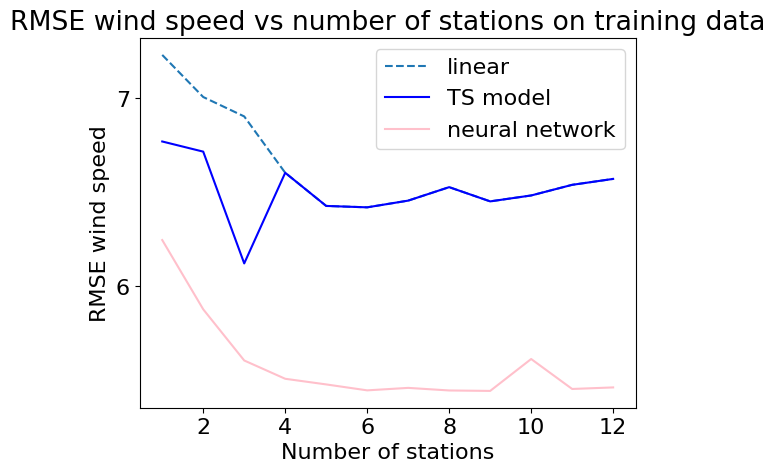

In [110]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
mlp_train_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in mlp_training_results:
     #li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     #fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
     #nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
     mlp_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7202)
# fcm_train_plot.insert(1, 6.6459)
# nn_train_plot.insert(1, 5.8963)

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on training data')

for exp in training_results:
    print('exp')
    print(f"{np.round(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]), 4)}±{np.round(np.std([d['linear_train'] for d in exp if 'linear_train' in d]),4)}")
    print(f"{np.round(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]), 4)}±{np.round(np.std([d['fcm_train'] for d in exp if 'fcm_train' in d]),4)}")
    print(f"{np.round(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]), 4)}±{np.round(np.std([d['nn_train'] for d in exp if 'nn_train' in d]),4)}")


In [15]:
mlp_test_results

[[{'nn_test': 6.8835757446289065},
  {'nn_test': 6.89691460609436},
  {'nn_test': 6.872444572448731}],
 [{'nn_test': 6.170784063339234},
  {'nn_test': 6.190897655487061},
  {'nn_test': 6.167893190383911}],
 [{'nn_test': 5.869408731460571},
  {'nn_test': 5.861469583511353},
  {'nn_test': 5.865467596054077}],
 [{'nn_test': 5.739485607147217},
  {'nn_test': 5.739493904113769},
  {'nn_test': 5.740940828323364}],
 [{'nn_test': 5.6822452640533445},
  {'nn_test': 5.680340604782105},
  {'nn_test': 5.6806598567962645}],
 [{'nn_test': 5.637230978012085},
  {'nn_test': 5.642211933135986},
  {'nn_test': 5.644328508377075}],
 [{'nn_test': 5.62014386177063},
  {'nn_test': 5.617525110244751},
  {'nn_test': 5.620292510986328}],
 [{'nn_test': 5.615935249328613},
  {'nn_test': 5.607531566619873},
  {'nn_test': 5.617669153213501}],
 [{'nn_test': 5.599444913864136},
  {'nn_test': 5.603193826675415},
  {'nn_test': 5.6034306716918945}],
 [{'nn_test': 5.6017499446868895},
  {'nn_test': 5.597394981384277},
  

Text(0.5, 1.0, 'RMSE wind speed vs number of stations on testing data')

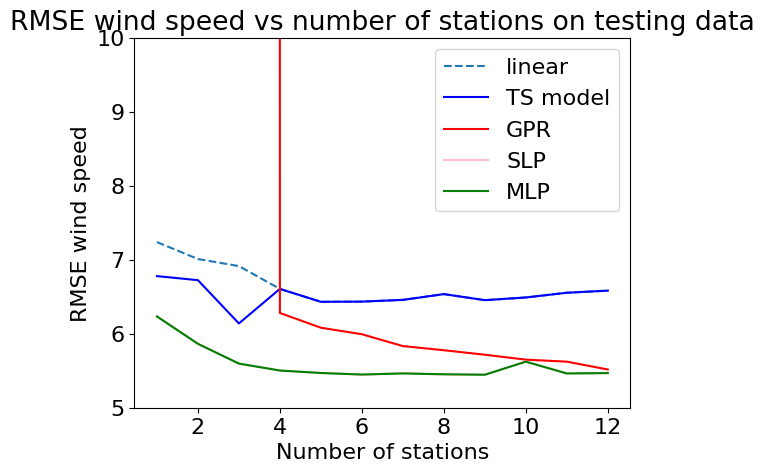

In [20]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []
mlp_test_plot = []

x_axis =  [1,2,3,4,5,6,7,8,9, 10, 11, 12]
for exp in test_results:
    li_train_plot.append(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]))
    fcm_train_plot.append(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]))
    nn_train_plot.append(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]))

for exp in gpr_test_results[0:12]:
    gpr_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))

for exp in mlp_test_results[0:12]:
    mlp_test_plot.append(np.mean([d['mlp_test'] for d in exp if 'mlp_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='TS model', c='blue')
plt.plot(x_axis, gpr_test_plot, label='GPR', c='red')
plt.plot(x_axis, nn_train_plot, label='SLP', c='pink')
plt.plot(x_axis, nn_train_plot, label='MLP', c='green')
plt.legend(loc="upper right")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')

# for exp in test_results:
#     print('exp')
#     print(f"{np.round(np.mean([d['linear_test'] for d in exp if 'linear_test' in d]), 4)}±{np.round(np.std([d['linear_test'] for d in exp if 'linear_test' in d]),4)}")
#     print(f"{np.round(np.mean([d['fcm_test'] for d in exp if 'fcm_test' in d]), 4)}±{np.round(np.std([d['fcm_test'] for d in exp if 'fcm_test' in d]),4)}")
#     print(f"{np.round(np.mean([d['nn_test'] for d in exp if 'nn_test' in d]), 4)}±{np.round(np.std([d['nn_test'] for d in exp if 'nn_test' in d]),4)}")


nan±nan


e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
e:\Users\PPL\anaconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


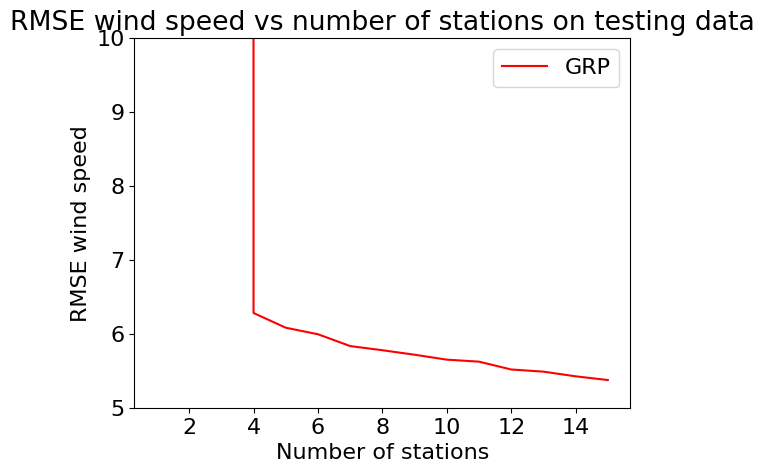

In [101]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
gpr_test_plot = []

x_axis = [1,2,3,4,5,6,7,8,9, 10,11,12,13,14,15]
for exp in gpr_test_results:
    gpr_test_plot.append(np.mean([d['gpr_test'] for d in exp if 'gpr_test' in d]))

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

# insert the optimal value from previous experiments 
# li_train_plot.insert(1, 6.7219)
# fcm_train_plot.insert(1, 6.6489)
# nn_train_plot.insert(1, 5.9011)


plt.plot(x_axis, gpr_test_plot, label='GRP', c='red')
plt.legend(loc="upper right")
plt.ylim(5,10)
plt.xlabel('Number of stations')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs number of stations on testing data')





In [108]:
result = []
for arr in gpr_test_results_opt:
    for d in arr:
        result.append(d['gpr_test'])

print(f"{np.round(np.mean(result), 4)}±{np.round(np.std(result),4)}")

5.4113±0.0273


Text(0.5, 1.0, 'Loss vs number of epoches')

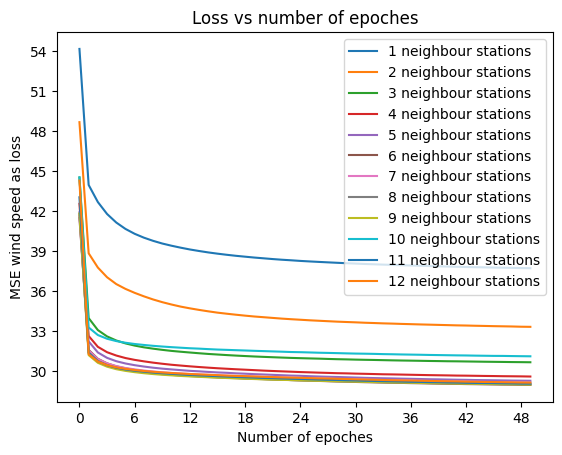

In [35]:
i = 1
fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))

for exp in nn_histories:
    nn_losses = []
    for fold in exp:
        nn_losses.append(fold['loss'])
    plt.plot(np.mean(nn_losses, axis=0), label=f"{i} neighbour stations")
    i = i+1


plt.legend(loc="upper right")
#plt.ylim(5)
plt.xlabel('Number of epoches')
plt.ylabel('MSE wind speed as loss')
plt.title('Loss vs number of epoches')

Text(0.5, 1.0, 'TS model optimization target Q v.s. iteration for differenct number of rules')

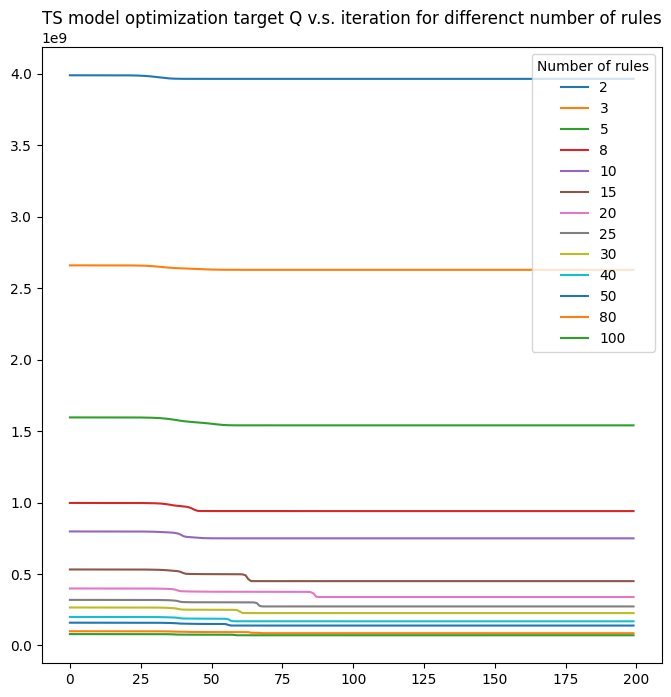

In [45]:
plt.figure(figsize=(8,8))

for exp in qs:
    plt.plot(exp)

plt.legend(FCM_Ncs, title="Number of rules")
plt.title('TS model optimization target Q v.s. iteration for differenct number of rules')